In [2]:
import pandas as pd
import numpy as np
import ast
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats




Statistical Results:
Statistic                 Value           Interpretation
----------------------------------------------------------------------
R²                        0.9866          Explains variance in temperature
Adjusted R²               0.9865          Accounts for number of predictors
P-value (const)           0.0000          Significant predictor
P-value (Dew point Avg)   0.0000          Significant predictor
P-value (Humidity Avg)    0.0000          Significant predictor
P-value (Wind Speed Avg)  0.2244          Not significant
F-test statistic          8888.0081       Overall significance of the model
F-test p-value            0.0000          Indicates model validity

Interpretations:
----------------------------------------------------------------------
R² indicates that 98.66% of the variance in temperature can be explained by dew point, humidity, and wind speed.
Adjusted R² adjusts R² based on the number of predictors; it helps assess the model's performance more a

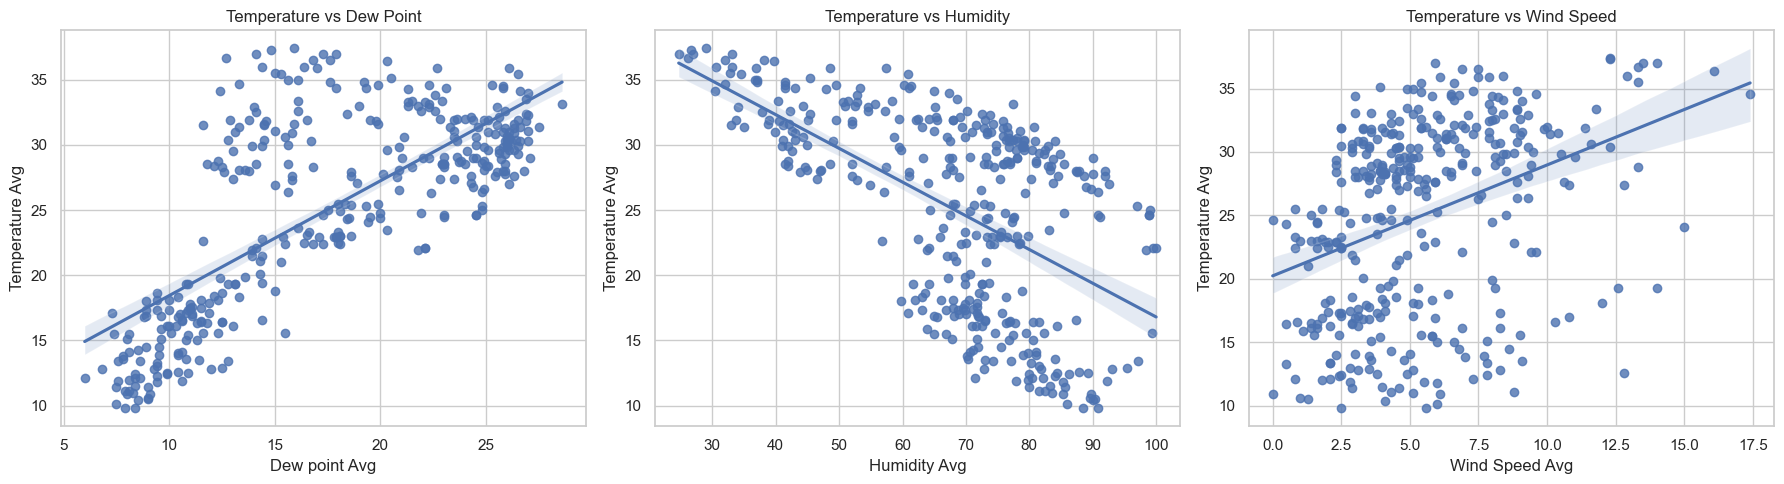

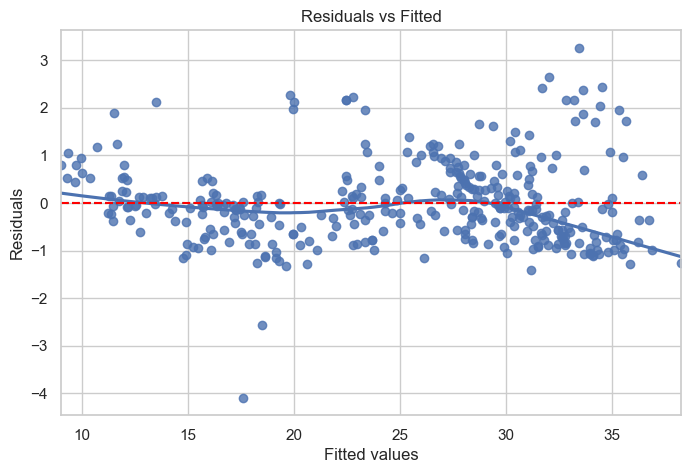

<Figure size 1000x800 with 0 Axes>

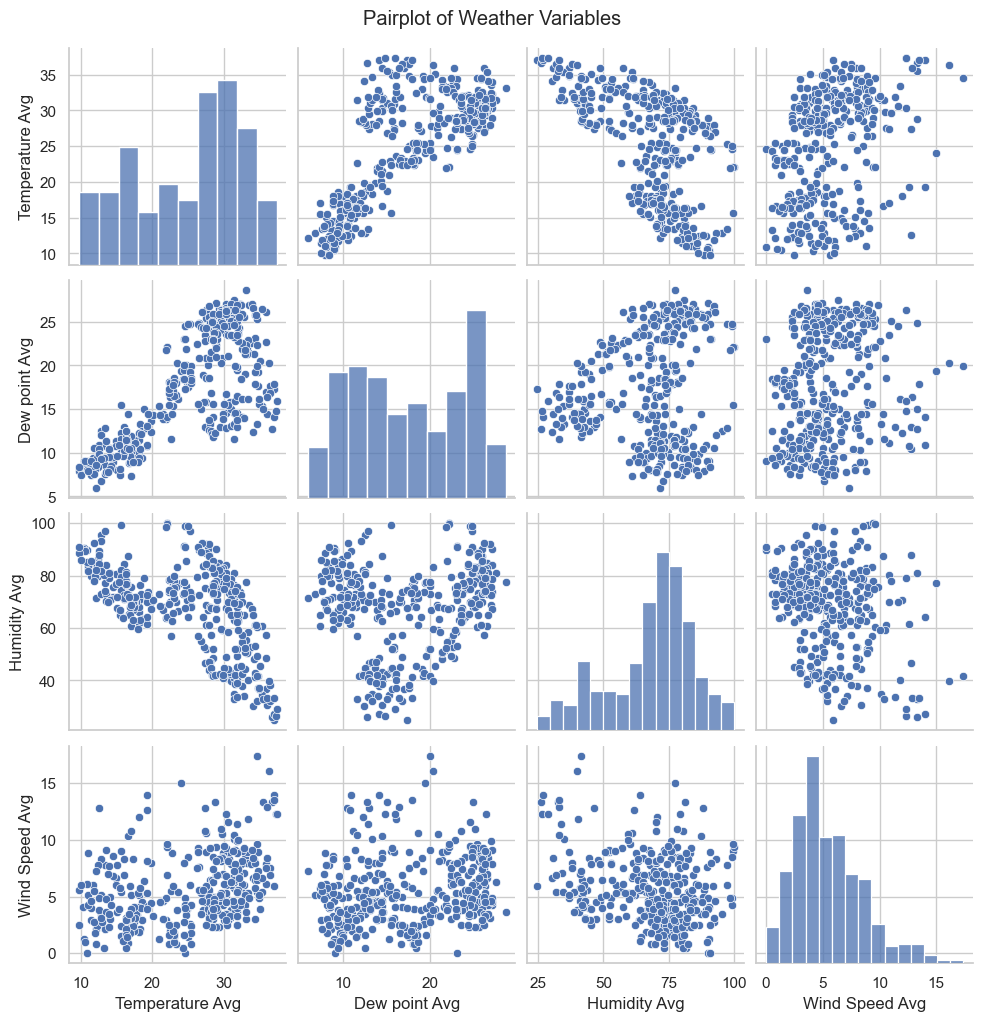

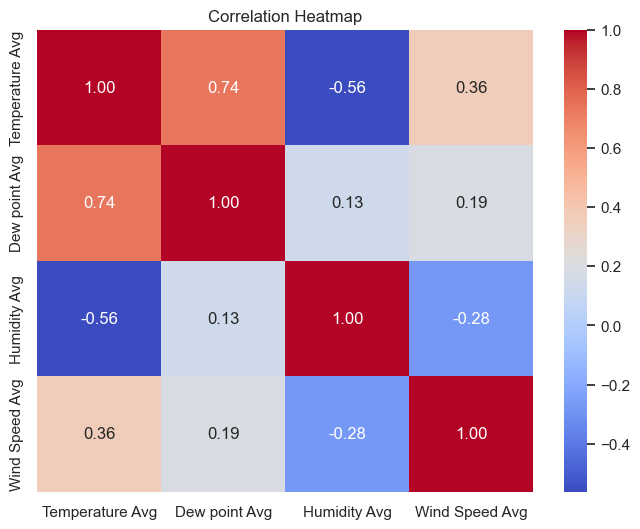

Shapiro-Wilk Test: Statistic=0.9437, p-value=0.0000
Residuals are not normally distributed.
T-test: t-statistic=-7.8588, p-value=0.0000
Significant difference in temperature between high and low humidity groups.
Predicted Temperature for sample input: 17.58 degrees


In [3]:
# Load the dataset from the provided CSV file
file_path = r"C:\Users\katya\Downloads\python project file.csv"
data = pd.read_csv(file_path)

# Data cleaning: Convert string representations of lists to actual lists and extract average values
def extract_avg(column):
    averages = []
    for x in column:
        try:
            # Convert string representation of list to actual list
            values = ast.literal_eval(x)
            # Check if it's a list and has enough elements
            if isinstance(values, list) and len(values) > 1:
                averages.append(np.mean(values[1]))  # Get average from 'Avg' index
            else:
                averages.append(np.nan)  # Append NaN if format is incorrect
        except (ValueError, SyntaxError):
            averages.append(np.nan)  # Append NaN if there's an error in parsing
    return averages

# Extract average values for each column
data['Temperature Avg'] = extract_avg(data['Temperature(degree)'])
data['Dew point Avg'] = extract_avg(data['Dew point(degree)'])
data['Humidity Avg'] = extract_avg(data['Humidity(%)'])
data['Wind Speed Avg'] = extract_avg(data['Wind Speed(Km/h)'])

# Drop rows with NaN values in the new average columns
data.dropna(subset=['Temperature Avg', 'Dew point Avg', 'Humidity Avg', 'Wind Speed Avg'], inplace=True)

# Prepare the data for regression analysis
X = data[['Dew point Avg', 'Humidity Avg', 'Wind Speed Avg']]
y = data['Temperature Avg']

# Add constant for intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Collect statistical results
r_squared = model.rsquared
adjusted_r_squared = model.rsquared_adj
p_values = model.pvalues
f_test = model.fvalue
f_test_p_value = model.f_pvalue

# Display results in tabular format using print statements with interpretations
print("\nStatistical Results:")
print(f"{'Statistic':<25} {'Value':<15} {'Interpretation'}")
print("-" * 70)
print(f"{'R²':<25} {r_squared:<15.4f} {'Explains variance in temperature'}")
print(f"{'Adjusted R²':<25} {adjusted_r_squared:<15.4f} {'Accounts for number of predictors'}")
for variable, p_value in p_values.items():
    conclusion = "Significant predictor" if p_value < 0.05 else "Not significant"
    print(f"{f'P-value ({variable})':<25} {p_value:<15.4f} {conclusion}")
print(f"{'F-test statistic':<25} {f_test:<15.4f} {'Overall significance of the model'}")
print(f"{'F-test p-value':<25} {f_test_p_value:<15.4f} {'Indicates model validity'}")

# Interpretations for each statistic:
print("\nInterpretations:")
print("-" * 70)
print("R² indicates that {:.2f}% of the variance in temperature can be explained by dew point, humidity, and wind speed.".format(r_squared * 100))
print("Adjusted R² adjusts R² based on the number of predictors; it helps assess the model's performance more accurately.")
for variable, p_value in p_values.items():
    if p_value < 0.05:
        print(f"The predictor '{variable}' has a p-value of {p_value:.4f}, indicating it significantly contributes to explaining temperature variation.")
    else:
        print(f"The predictor '{variable}' has a p-value of {p_value:.4f}, suggesting it does not significantly contribute to temperature variation.")
print("The F-test statistic of {:.4f} with a p-value of {:.4f} suggests that at least one predictor is significantly related to temperature.".format(f_test, f_test_p_value))

# Visualizations

# Set style for seaborn plots
sns.set(style="whitegrid")

# Scatter plots with regression line for each predictor
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.regplot(x='Dew point Avg', y='Temperature Avg', data=data, ax=axes[0])
axes[0].set_title('Temperature vs Dew Point')

sns.regplot(x='Humidity Avg', y='Temperature Avg', data=data, ax=axes[1])
axes[1].set_title('Temperature vs Humidity')

sns.regplot(x='Wind Speed Avg', y='Temperature Avg', data=data, ax=axes[2])
axes[2].set_title('Temperature vs Wind Speed')

plt.tight_layout()
plt.show()

# Residual plot to check homoscedasticity
plt.figure(figsize=(8, 5))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(0, linestyle='--', color='red')
plt.show()

# Additional visualizations: Pairplot and heatmap of correlations
plt.figure(figsize=(10, 8))
sns.pairplot(data[['Temperature Avg', 'Dew point Avg', 'Humidity Avg', 'Wind Speed Avg']])
plt.suptitle('Pairplot of Weather Variables', y=1.02)
plt.show()

# Correlation heatmap
correlation_matrix = data[['Temperature Avg', 'Dew point Avg', 'Humidity Avg', 'Wind Speed Avg']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Statistical tests: Shapiro-Wilk test for normality of residuals
shapiro_test = stats.shapiro(model.resid)
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}')
if shapiro_test.pvalue < 0.05:
    print("Residuals are not normally distributed.")
else:
    print("Residuals are normally distributed.")

# T-test example: Compare temperature means between two groups (e.g., high humidity vs low humidity)
high_humidity_group = data[data['Humidity Avg'] > data['Humidity Avg'].median()]['Temperature Avg']
low_humidity_group = data[data['Humidity Avg'] <= data['Humidity Avg'].median()]['Temperature Avg']
t_statistic, t_p_value = stats.ttest_ind(high_humidity_group, low_humidity_group)

print(f'T-test: t-statistic={t_statistic:.4f}, p-value={t_p_value:.4f}')
if t_p_value < 0.05:
    print("Significant difference in temperature between high and low humidity groups.")
else:
    print("No significant difference in temperature between high and low humidity groups.")

# Sample Testing: Predicting temperature for a sample input using the regression model.
sample_input = pd.DataFrame({
    'const': [1],  # Intercept term
    'Dew point Avg': [12.0],  # Sample dew point value
    'Humidity Avg': [75.0],    # Sample humidity value
    'Wind Speed Avg': [10.0]    # Sample wind speed value
})

predicted_temperature = model.predict(sample_input)
print(f"Predicted Temperature for sample input: {predicted_temperature[0]:.2f} degrees")